In [1]:
import argparse
import corner
import datetime
import heliosat
import logging
import numpy as np
import os
import pickle
import py3dcore
import sys
import pytz

import matplotlib

from matplotlib import rcParams
rcParams["font.size"] = 12

from mpl_toolkits.mplot3d import Axes3D

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from py3dcore._extnumba import set_random_seed
from py3dcore.util import configure_logging, select_model
from heliosat.satellites import select_satellite

c0 = "xkcd:black"
c1 = "xkcd:magenta"
c2 = "xkcd:orange"
c3 = "xkcd:azure"

UKTZ = pytz.timezone("Europe/London")

ModuleNotFoundError: No module named 'corner'

In [33]:
def load_file(path, ref, D=8, ax=None, **kwargs):
    obj = py3dcore.fitting.ABCSMC()
    obj.load(path)

    if isinstance(ref, str):
        ref_sat = getattr(heliosat, ref.upper())
    else:
        ref_sat = ref
    
    t = [obj.t_launch + datetime.timedelta(hours=0, minutes=15*i) for i in range(0, 4 * 24 * 7)]
    
    new_data = pickle.load(open("/nas/helio/data/insitu_python/solo_2020_icme_april_new_proc_rtn.p", "rb"))
    new_t = np.array([_[0].replace(tzinfo=datetime.timezone.utc) for _ in new_data])
    new_b = np.array([[_[1], _[2], _[3]] for _ in new_data]).astype(np.float64)

    # transform frame
    #new_b_sel_hci = heliosat.coordinates.transform_pos(t_fit, new_b_sel, "SOLO_SUN_RTN", "HCI")
    
    tb2, b2= ref_sat().get_data(t, "mag", frame="SOLO_SUN_RTN", cache=True, smoothing="kernel",
                                smoothing_scale=240, remove_nans=True, return_datetimes=True)

    model_obj = obj.model(obj.t_launch, runs=len(obj.particles), use_gpu=False)
    model_obj.update_iparams(obj.particles, seed=142)
            
    ensemble = np.squeeze(np.array(model_obj.sim_fields(tb2, ref_sat().trajectory(tb2, frame="HCI"))))

    ensemble = ensemble.reshape((len(obj.particles), len(tb2), 3))[::D]
    ensemble = ensemble.reshape((len(tb2), len(obj.particles) // D, 3))
    
    ensemble = heliosat.coordinates.transform_pos(tb2, ensemble, "HCI", "SOLO_SUN_RTN")
    
    ensemble[np.where(ensemble == 0)] = np.nan

    b_m = np.nanmean(ensemble, axis=1)
    b_q1 = np.nanquantile(ensemble, 0.5 + 0.68 / 2, axis=1)
    b_q2 = np.nanquantile(ensemble, 0.5 - 0.68 / 2, axis=1)
    
    b_q3 = np.nanquantile(ensemble, 0.5 + 0.95 / 2, axis=1)
    b_q4 = np.nanquantile(ensemble, 0.5 - 0.95 / 2, axis=1)

    b_t = np.sqrt(np.sum(ensemble**2, axis=2))
    
    b_tq1 = np.nanquantile(b_t, 0.5 + 0.68 / 2, axis=1)
    b_tq2 = np.nanquantile(b_t, 0.5 - 0.68 / 2, axis=1)
    
    b_tq3 = np.nanquantile(b_t, 0.5 + 0.95 / 2, axis=1)
    b_tq4 = np.nanquantile(b_t, 0.5 - 0.95 / 2, axis=1)

    if ax:
        ax.plot(tb2, np.sqrt(np.sum(b_m**2, axis=1)), ls="-", color=c0, lw=2)
        ax.plot(tb2, b_m[:, 0], ls="--", color=c1, lw=2)
        ax.plot(tb2, b_m[:, 1], ls="--", color=c2, lw=2)
        ax.plot(tb2, b_m[:, 2], ls="--", color=c3, lw=2)

        #ax.fill_between(tb2, b_tq1, b_tq2, color=c0, alpha=0.20)
        #ax.fill_between(tb2, b_q1[:, 0], b_q2[:, 0], color=c1, alpha=0.20)
        #ax.fill_between(tb2, b_q1[:, 1], b_q2[:, 1], color=c2, alpha=0.20)
        #ax.fill_between(tb2, b_q1[:, 2], b_q2[:, 2], color=c3, alpha=0.20)
        
        ax.fill_between(tb2, b_tq3, b_tq4, color=c0, alpha=0.1)
        ax.fill_between(tb2, b_q3[:, 0], b_q4[:, 0], color=c1, alpha=0.1)
        ax.fill_between(tb2, b_q3[:, 1], b_q4[:, 1], color=c2, alpha=0.1)
        ax.fill_between(tb2, b_q3[:, 2], b_q4[:, 2], color=c3, alpha=0.1)

        ax.scatter(new_t, np.sqrt(np.sum(new_b**2, axis=1)), color=c0, s=1)
        ax.scatter(new_t, new_b[:, 0], s=1, color=c1)
        ax.scatter(new_t, new_b[:, 1], s=1, color=c2)
        ax.scatter(new_t, new_b[:, 2], s=1, color=c3)
        
        ax.plot(tb2, np.sqrt(np.sum(b2**2, axis=1)), color=c0)
        ax.plot(tb2, b2[:, 0], color=c1)
        ax.plot(tb2, b2[:, 1], color=c2)
        ax.plot(tb2, b2[:, 2], color=c3)

        for _ in obj.t_data:
            ax.axvline(x=_, ls="--", color="grey", lw=1.5, alpha=0.5)
        
        ax.fill_between([obj.t_data[0], obj.t_data[-1]], [1e6, 1e6], [-1e6, -1e6], color=c0, alpha=0.035)

        ax.set_xlabel("Time (MM-DD HH)", fontsize=24)
        ax.set_ylabel("B (nT)", fontsize=24)
        ax.set_ylim([-25, 25])
        ax.grid(True)
        
        title = kwargs.get("title", None)
        limits = kwargs.get("limits", None)

        if title:
            ax.set_title(title, fontsize=24)

        if limits:
            ax.set_xlim(limits)

        ax.legend(handles=[
                Line2D([], [], color=c0, ls="-", lw=5, label="$|B|$"),
                Line2D([], [], color=c1, ls="-", lw=5, label="$B_R$"),
                Line2D([], [], color=c2, ls="-", lw=5, label="$B_T$"),
                Line2D([], [], color=c3, ls="-", lw=5, label="$B_N$")
            ],
            fontsize=24, loc="lower right", framealpha=1)
    
        ax.tick_params(axis='both', which='major', labelsize=18)
        
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        
    return obj.particles

<ipython-input-33-ffd491ebee70>:34: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/aweiss/miniconda3/envs/weiss2020_3dcore/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


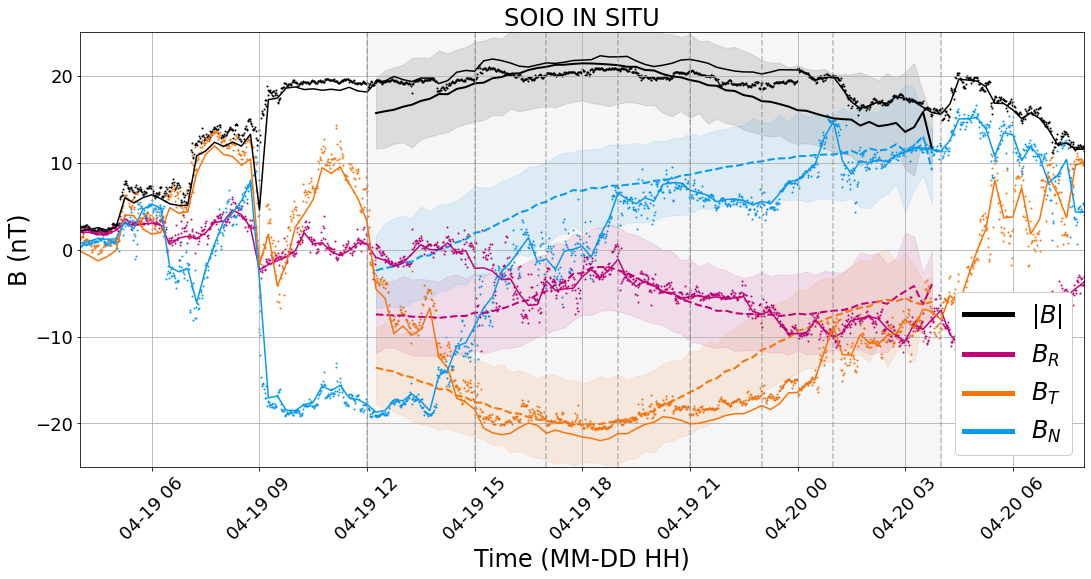

In [34]:
DATAPATH = "/home/aweiss/data/SolarOrbiter"

class SOLO_EXT(heliosat.SOLO):
    def get_data_files(self, *args):
        files = os.listdir(DATAPATH)
        files.sort()
        files = [os.path.join(DATAPATH, f) for f in files]

        range_start, range_end, data_key = args

        if range_end < range_start:
            raise ValueError("starting date must be after final date")

        data_key = self.resolve_data_key(data_key)

        # adjust ranges slightly
        range_start -= datetime.timedelta(hours=range_start.hour, minutes=range_start.minute,
                                          seconds=range_start.second + 1)
        if range_end.hour == 0 and range_end.minute == 0 and range_end.second == 0:
            range_end -= datetime.timedelta(seconds=1)
            
        # filter out files
        # get date for each file
        files_dates = np.array([
            datetime.datetime.strptime(os.path.basename(_)[:-8][-8:], "%Y%m%d").replace(tzinfo=datetime.timezone.utc) for _ in files
        ])
        
        mask = (files_dates > range_start) & (files_dates < range_end)
        
        files_selected = np.array(files)[mask]
        files_selected_dates = np.array(files_dates)[mask]

        return files_selected, [self.get_data_version("mag", _) for _ in files_selected_dates]

fig, ax1 = plt.subplots(1, 1, figsize=(18, 8))

soio_particles = load_file("/home/aweiss/data/april_event/SOLO_APRIL_FORBUSH_FIXED_DELTA_6", SOLO_EXT, ax=ax1, D=8,
                           limits=[datetime.datetime(2020, 4, 19, 4), datetime.datetime(2020, 4, 20, 8)], title="SOIO IN SITU")

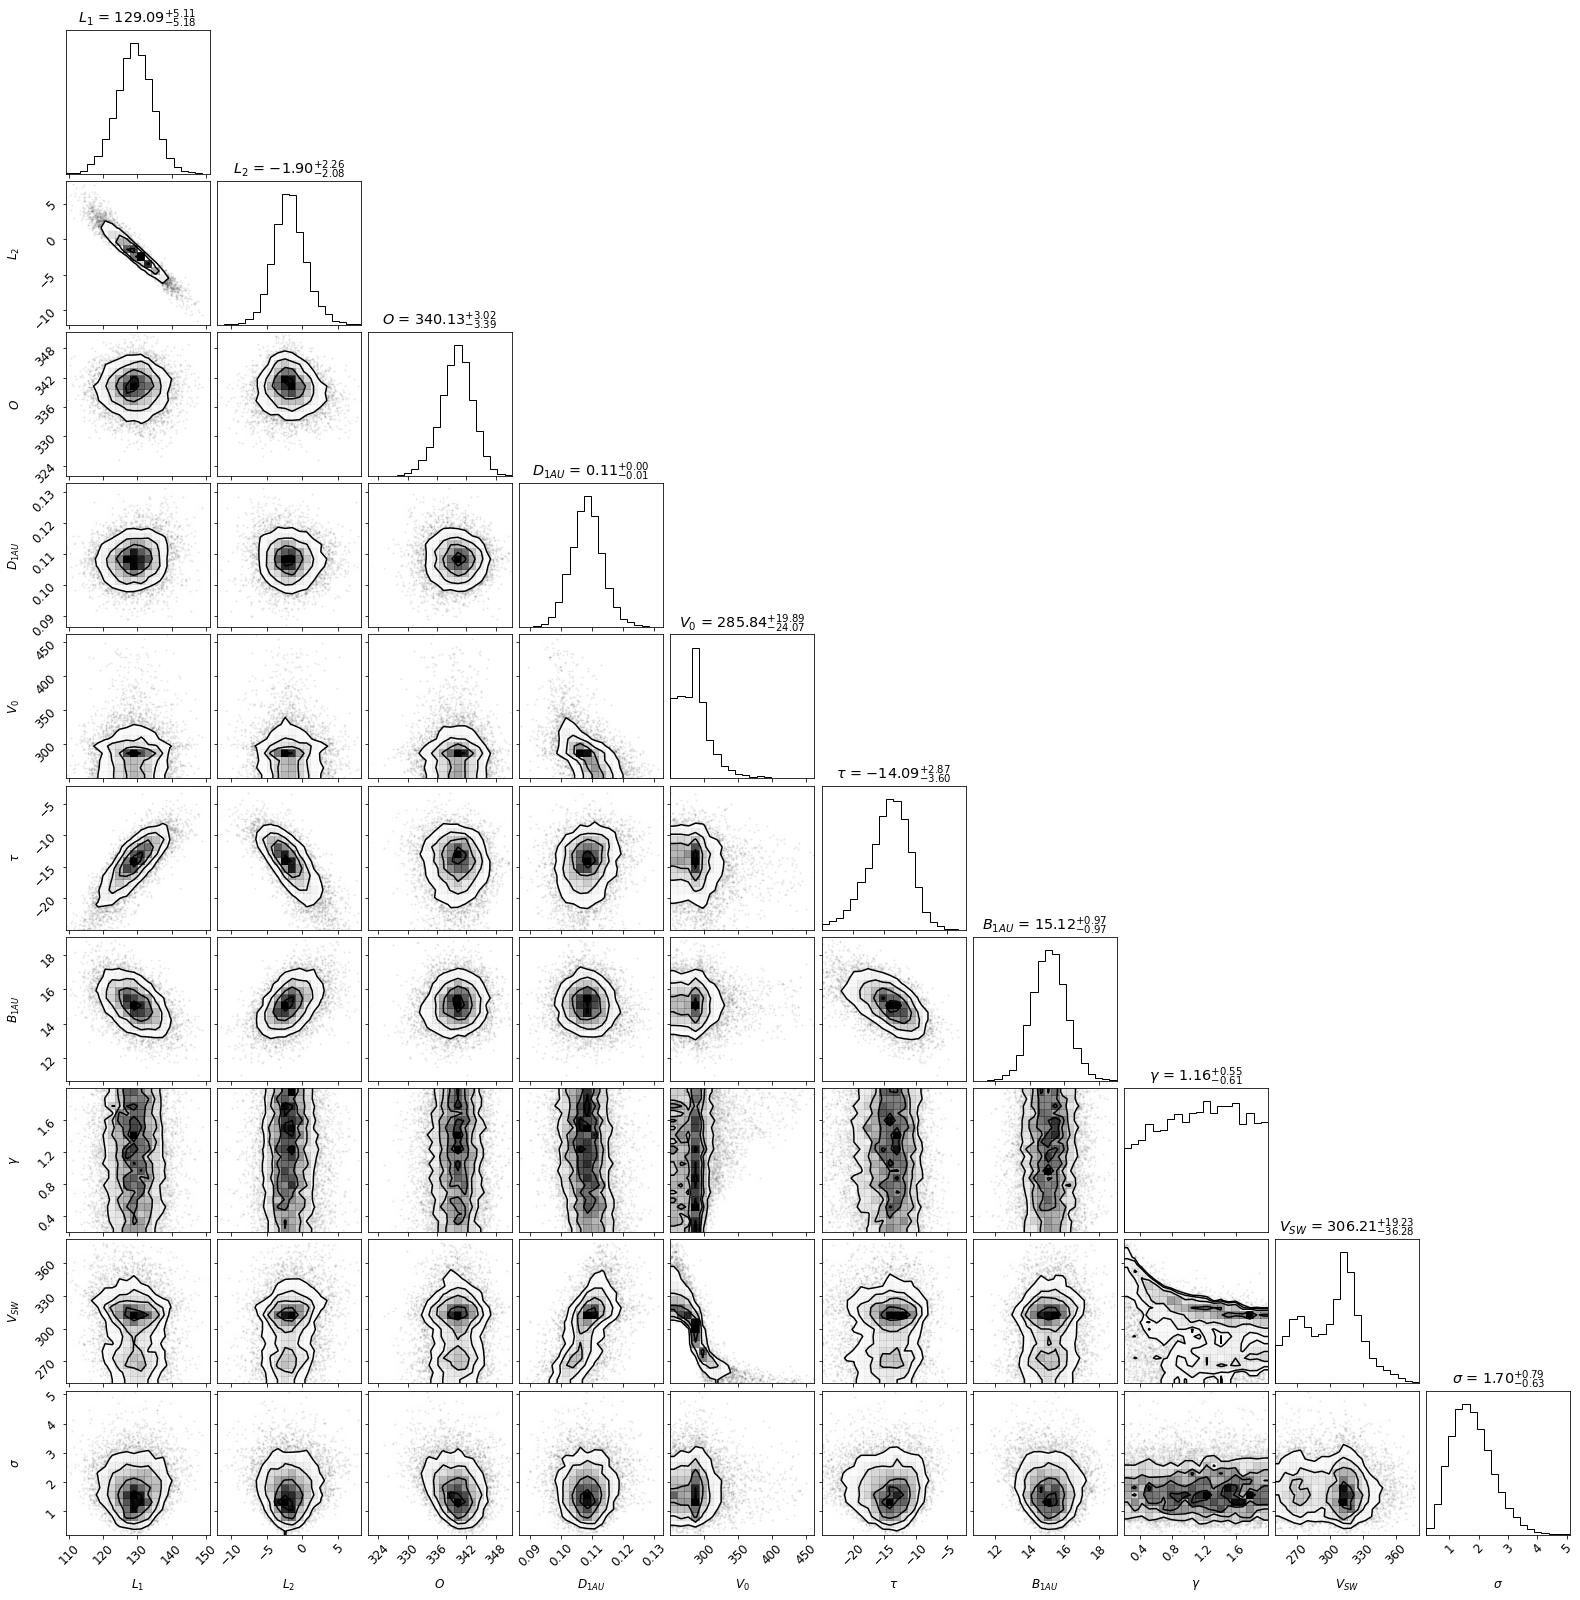

In [11]:
selector = [1, 2, 3, 4, 8, 9, 12, 13, 14, 15]#, 4, 5, 8, 10, 11, 13]

labels = ["${0}$".format(v["label"]) for k, v in py3dcore.models.TTGHv2.default_parameters().items()]

obj = py3dcore.fitting.ABCSMC()
obj.load("/home/aweiss/data/april_event/SOLO_APRIL_FORBUSH_FIXED_DELTA_5")
cfig = corner.corner(obj.particles[:, selector], show_titles=True, labels=np.array(labels)[selector], color="k")

plt.show()

In [5]:
obj = py3dcore.fitting.ABCSMC()
obj.load("/home/aweiss/data/april_event/SOLO_APRIL_FORBUSH_FIXED_DELTA_5")

l1l2_rtn = heliosat.coordinates.transform_lonlat(obj.t_launch, obj.particles[:, 1:3], "HCI", "HEEQ")
labels = ["${0}$".format(v["label"]) for k, v in py3dcore.models.TTGHv2.default_parameters().items()]

def print_result(arr, lbl):
    print("{0}: {1:.2f} +/- {2:.2f}".format(lbl, np.mean(arr), np.std(arr)))
    
print_result(l1l2_rtn[:, 0], labels[1])
print_result(l1l2_rtn[:, 1], labels[2])

for i in range(3, 16):
    print_result(obj.particles[:, i], labels[i])

$L_1$: 4.23 +/- 3.30
$L_2$: -1.82 +/- 2.34
$O$: 339.96 +/- 3.36
$D_{1AU}$: 0.11 +/- 0.01
$w$: 1.00 +/- 0.00
$\delta$: 4.00 +/- 0.00
$R_0$: 20.00 +/- 0.00
$V_0$: 286.63 +/- 25.97
$\tau$: -14.41 +/- 3.32
$n_a$: 1.14 +/- 0.00
$n_b$: 1.64 +/- 0.00
$B_{1AU}$: 15.13 +/- 1.00
$\gamma$: 1.14 +/- 0.50
$V_{SW}$: 301.28 +/- 26.21
$\sigma$: 1.78 +/- 0.71


In [6]:
l1l2_rtn.shape

(8192, 2)